In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from imblearn.over_sampling import SMOTE
import pandas as pd 
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def init_spark():
    spark = SparkSession.builder.appName("Python Spark SQL basic example").config("spark.some.config.option", "some-value").getOrCreate()
    return spark
spark_object = init_spark()

Training data encoding and smote balancing 

In [3]:
train_spark = spark_object.read.option("delimiter", ",").csv("./data/traincleaned.csv", header='true', inferSchema='true')
train_spark = train_spark.drop(col("_c0"))
train_spark = train_spark.drop(col("id_31"))

In [4]:
train_pandas = train_spark.toPandas()

In [5]:
imputer = KNNImputer(n_neighbors=5)


In [6]:
cat_cols = [col for col in train_pandas.columns if train_pandas[col].dtype == 'object']

In [7]:
X_train_temp = pd.get_dummies(train_pandas.drop('isFraud', axis=1), columns=cat_cols)
y_train = train_pandas['isFraud']

X_train = pd.DataFrame(imputer.fit_transform(X_train_temp), columns=X_train_temp.columns)

Before SMOTE


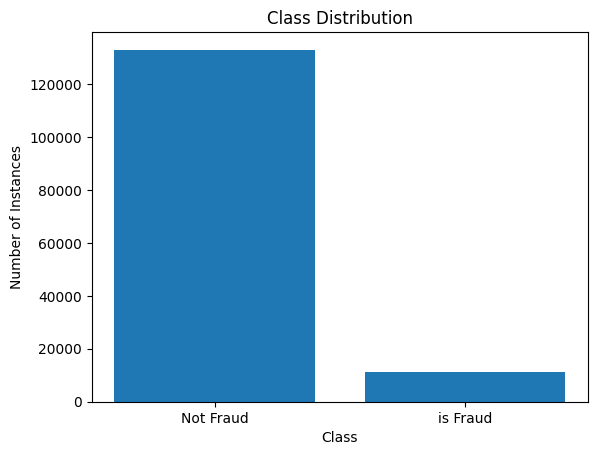

In [8]:
print('Before SMOTE')

class_counts_before = np.bincount(y_train)

plt.bar(range(len(class_counts_before)), class_counts_before)
plt.xticks(range(len(class_counts_before)), ['Not Fraud', 'is Fraud'])
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution')
plt.show()

In [9]:
sm = SMOTE(random_state=42)

In [10]:
X_sm, y_sm = sm.fit_resample(X_train, y_train)


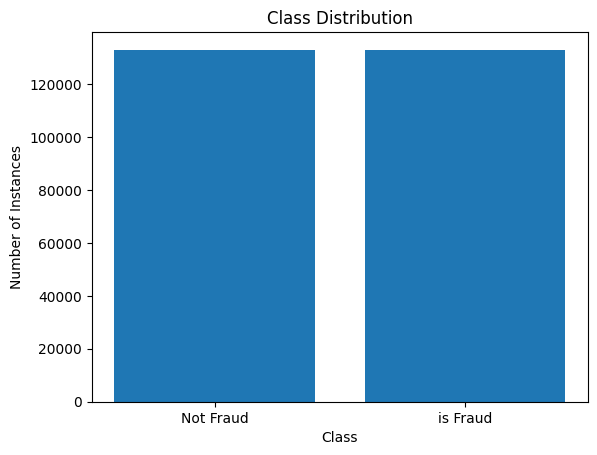

In [13]:


class_counts_after = np.bincount(y_sm)

plt.bar(range(len(class_counts_after)), class_counts_after)
plt.xticks(range(len(class_counts_after)), ['Not Fraud', 'is Fraud'])
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution')
plt.show()


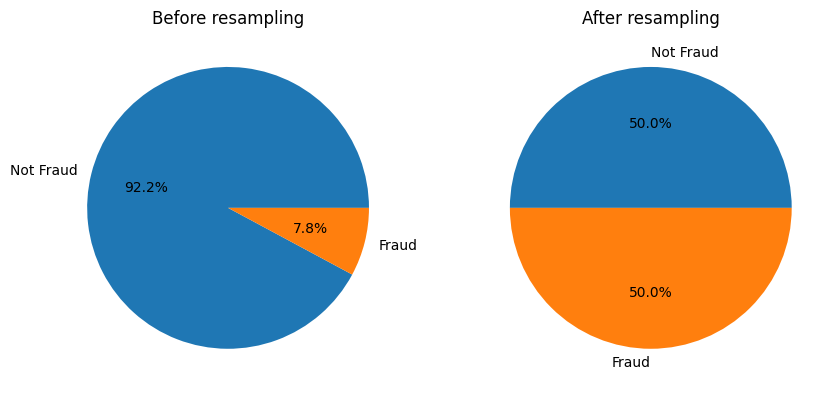

In [14]:
# Plot the data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

classes=['Not Fraud' ,'Fraud']

# Plot before resampling
ax1.pie(class_counts_before, labels=classes, autopct='%1.1f%%')
ax1.set_title('Before resampling')

# Plot after resampling
ax2.pie(class_counts_after, labels=classes, autopct='%1.1f%%')
ax2.set_title('After resampling')

plt.show()

Stacked Bar Chart


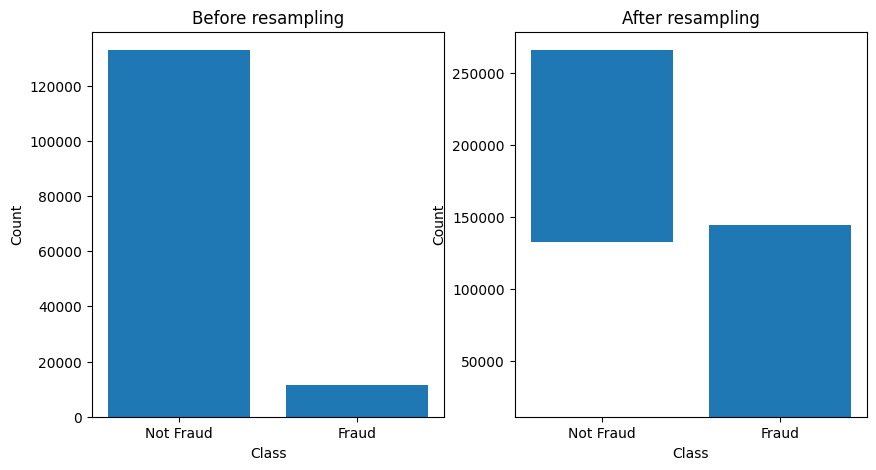

In [15]:
# Plot the data
print('Stacked Bar Chart')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot before resampling
ax1.bar(classes, class_counts_before)
ax1.set_title('Before resampling')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')

# Plot after resampling
ax2.bar(classes, class_counts_after, bottom=class_counts_before)
ax2.set_title('After resampling')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')

plt.show()

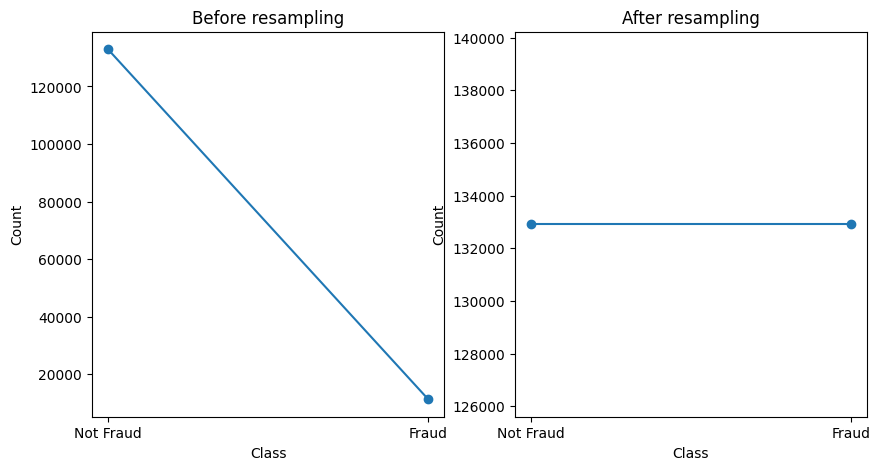

In [16]:
# Plot the data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot before resampling
ax1.plot(classes, class_counts_before, 'o-')
ax1.set_title('Before resampling')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')

# Plot after resampling
ax2.plot(classes, class_counts_after, 'o-')
ax2.set_title('After resampling')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')

plt.show()

In [17]:
train_balanced_data = pd.concat([X_sm, y_sm], axis=1)
# print((train_balanced_data.count(), len(train_balanced_data.columns)))
train_balanced_data.to_csv('./data/trainbalanced.csv', index=False)

test data encoding 

In [11]:
test_spark = spark_object.read.option("delimiter", ",").csv("./data/testcleaned.csv", header='true', inferSchema='true')
test_spark = test_spark.drop(col("_c0"))
test_spark = test_spark.drop(col("id_31"))
print(len(test_spark.columns))

192


In [12]:
test_pandas = test_spark.toPandas()

In [13]:
dog_cols = [col for col in test_pandas.columns if test_pandas[col].dtype == 'object']

In [14]:
X_test = pd.get_dummies(test_pandas,columns=dog_cols)

In [18]:
# print((X_test.count(), len(X_test.columns)))
# print((train_balanced_data.count(), len(train_balanced_data.columns)))

(TransactionID         141907
TransactionDT         141907
TransactionAmt        141907
card1                 141907
card2                 139410
                       ...  
id_37_T               141907
id_38_F               141907
id_38_T               141907
DeviceType_desktop    141907
DeviceType_mobile     141907
Length: 210, dtype: int64, 210)
(TransactionID         265830
TransactionDT         265830
TransactionAmt        265830
card1                 265830
card2                 265830
                       ...  
id_38_F               265830
id_38_T               265830
DeviceType_desktop    265830
DeviceType_mobile     265830
isFraud               265830
Length: 211, dtype: int64, 211)


In [37]:
X_test.to_csv('./data/testbalanced.csv', index=False)